## Project: Build a Traffic Sign Recognition Classifier

This notebook contains the implemetnation of Traffic sign classifier based on the LeNet architecure which is a convolution neural network. The following steps are used to create the classfier, pipeline and training process.

- Load the data.
- Understanding and Visualising the data.
- Define training set, validation set and test set.
- Design of Pipeline.
- Training of Network.
- Run Benchmark model without any preprocessing.
- Preprocessing the data for usage.
    - Use of different normalisation methods.
    - Apply different image augmentation methods.
- Measure of system performance.
- Tunning of system performance.
- Run classifier on Test data.

---
## Step 0: Load The Data

The data set provided are the traffic signs sampled from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset), as pickled files. These files are already preprocessed to be 32x32x3 colourmap image library set.

In [1]:
# Load all necessary libraries
import pickle
import os
import pandas as pd
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from LeNet5 import lenet5
import cv2
from tqdm import tqdm
from collections import Counter
import glob

# Visualizations will be shown in the notebook.
%matplotlib inline

In [36]:
# Load pickled data

# Root folder for the training data set
rootDir = r"./traffic-signs-data"

# Traffic sign identifier text csv file path
signcsvname = "signnames.csv"

# data set files path
training_file = os.path.join(rootDir, "train.p")
validation_file = os.path.join(rootDir, "valid.p")
testing_file = os.path.join(rootDir, "test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
Org_X_train, Org_y_train = train['features'], train['labels']
Org_X_valid, Org_y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Creating a validation set using split function
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(Org_X_train, Org_y_train, test_size=0.2, random_state=0)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [37]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = np.shape(Org_X_train)[0]

# TODO: Number of validation examples
n_validation = np.shape(Org_X_valid)[0]

# TODO: Number of testing examples.
n_test = np.shape(X_test)[0]

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(Org_X_train[0])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(Org_y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

In [4]:
# A function provide a random sample of images from a given dataset and labels
def getrandomset(dataset, label, nsample):
    '''
    This function generates random dataset based on the number of sample defined.
    
    :param dataset: the entire dataset from which random sample has to be selected
    :param label: the ylabel dataset from which the indices are randomised
    :param nsample: Number of random samples to be returned
    '''
    dataset, label =  shuffle(dataset, label)
    rand_ind = np.random.choice(label, size=nsample, replace=False)
    sample_dataset = dataset[rand_ind]
    sample_label = label[rand_ind]
    
    return sample_dataset, sample_label

In [5]:
def plotrandom(dataset, label, label_dict, dispoption=None):
    '''
    This fucntion plots the given dataset as subplot and its corresponding label.
    
    :param dataset: sample of dataset to be plotted
    :param label: identifier of the dataset
    :param label_dict: dictionary of the label identifier
    '''
    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    n_dataset = np.shape(dataset)[0]
    if n_dataset <= 5:
        nrows = 1
        ncols = n_dataset
    else:
        nrows = ceil(n_dataset/5)
        ncols = 5
    for i in range(n_dataset):
        x = dataset[i]
        y = str(label[i]) + " " + label_dict[label[i]]
        plt.subplot(nrows, ncols, i+1)
        if dispoption is not None:
            plt.imshow(x, cmap=dispoption)
        else:
            plt.imshow(x)
        plt.imshow(x)
        plt.axis('off')
        plt.text(0,0,y, fontsize=9, backgroundcolor='y')
    plt.show()

In [6]:
def readLabel(csvfname):
    '''
    this function reads the traffic sign label name and returns dictionary of 
    the labels.
    
    :param csvfname: filepath of the sign label identifier
    '''
    dataframe = pd.read_csv(csvfname)
    label_dict = pd.Series(dataframe.SignName, index=dataframe.ClassId).to_dict()
    
    return label_dict

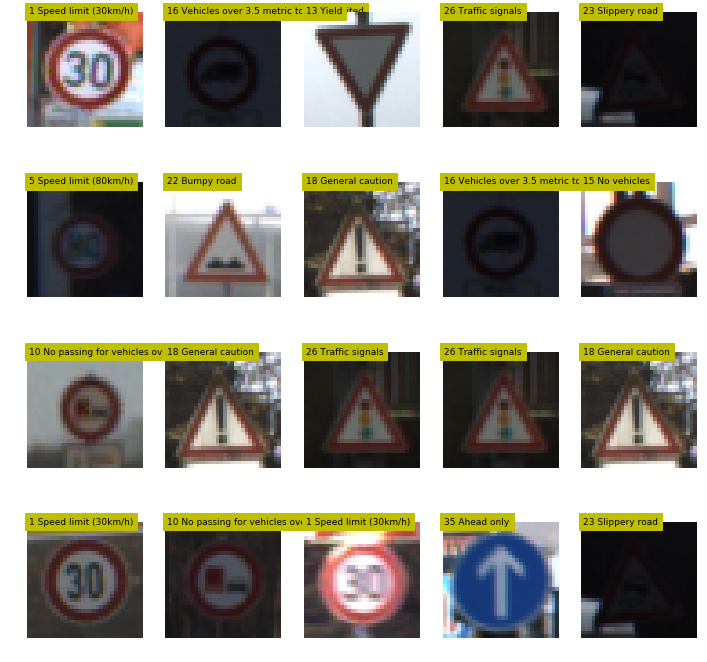

In [7]:
# Get random set of traffic sign to visualise them
dataset, label = getrandomset(X_train, y_train, 20)

# generate label dictionary to identify the traffic signs
label_dict = readLabel(signcsvname)

# Plot traffic signs
plotrandom(dataset, label, label_dict)

In [58]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

In order to train the classifier the given dataset has to be understand in terms of distribution of training and validation sets. The training set and test set traffic sign distribution are analysed. 
- Not all signs are off equal count
- Most number of signs are speeds, keep right etc.,

Inrelaistic scenario this is what a human would observe.

In [59]:
def plothist(dataset, label):
    '''
    Function to plot distribution of the traffic sign based on y and label index
    '''
    # Convert label dictionary to list
    sign_label = []
    for key, value in label.items():
        sign_label.append(value)
    counted = np.bincount(dataset)
    plt.figure(111,figsize = (16,16))
    bar_pos = np.arange(len(label)) + 0.5 # this will center the histogram
    plt.barh(bar_pos, counted, align='center', color='green')
    plt.yticks(bar_pos,sign_label)
    plt.xlabel("Traffic Sign Count")

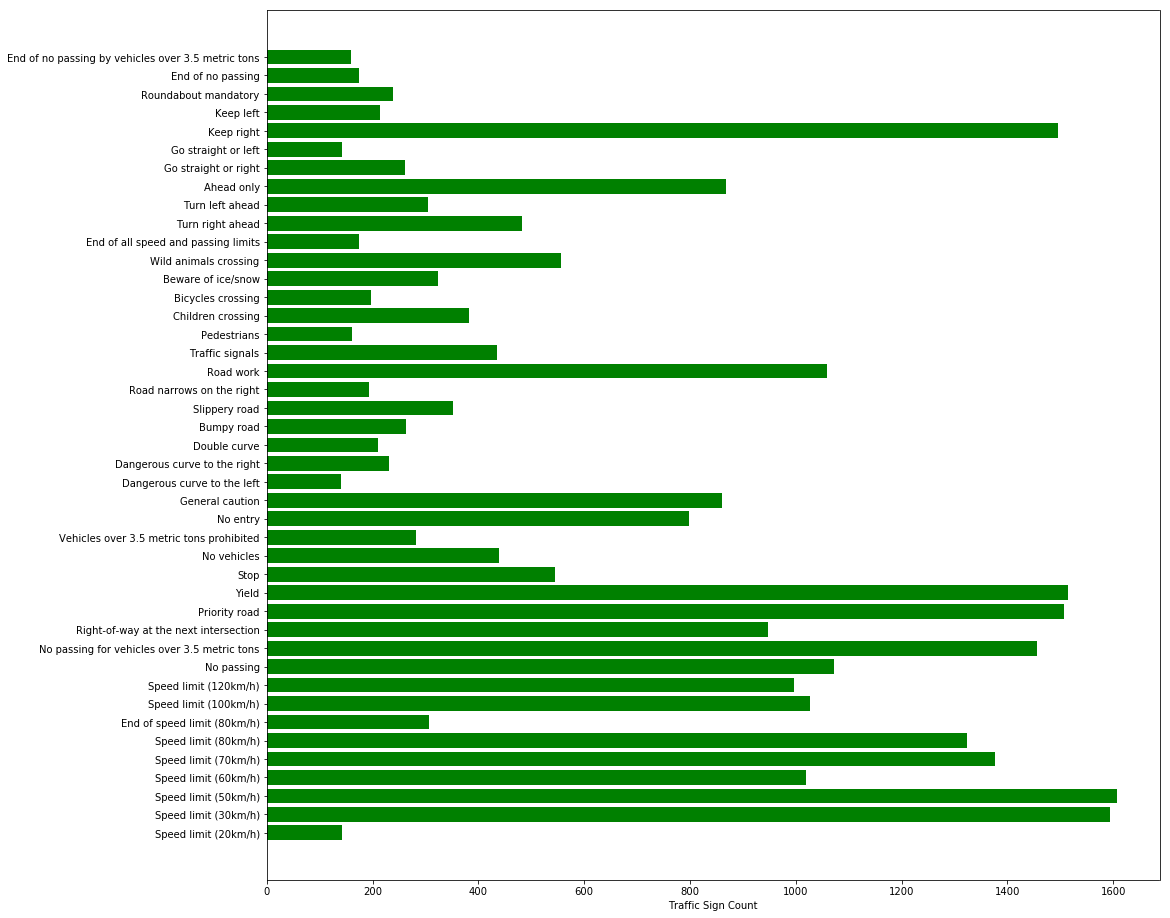

In [60]:
# Visualising Training Set
plothist(y_train, label_dict)

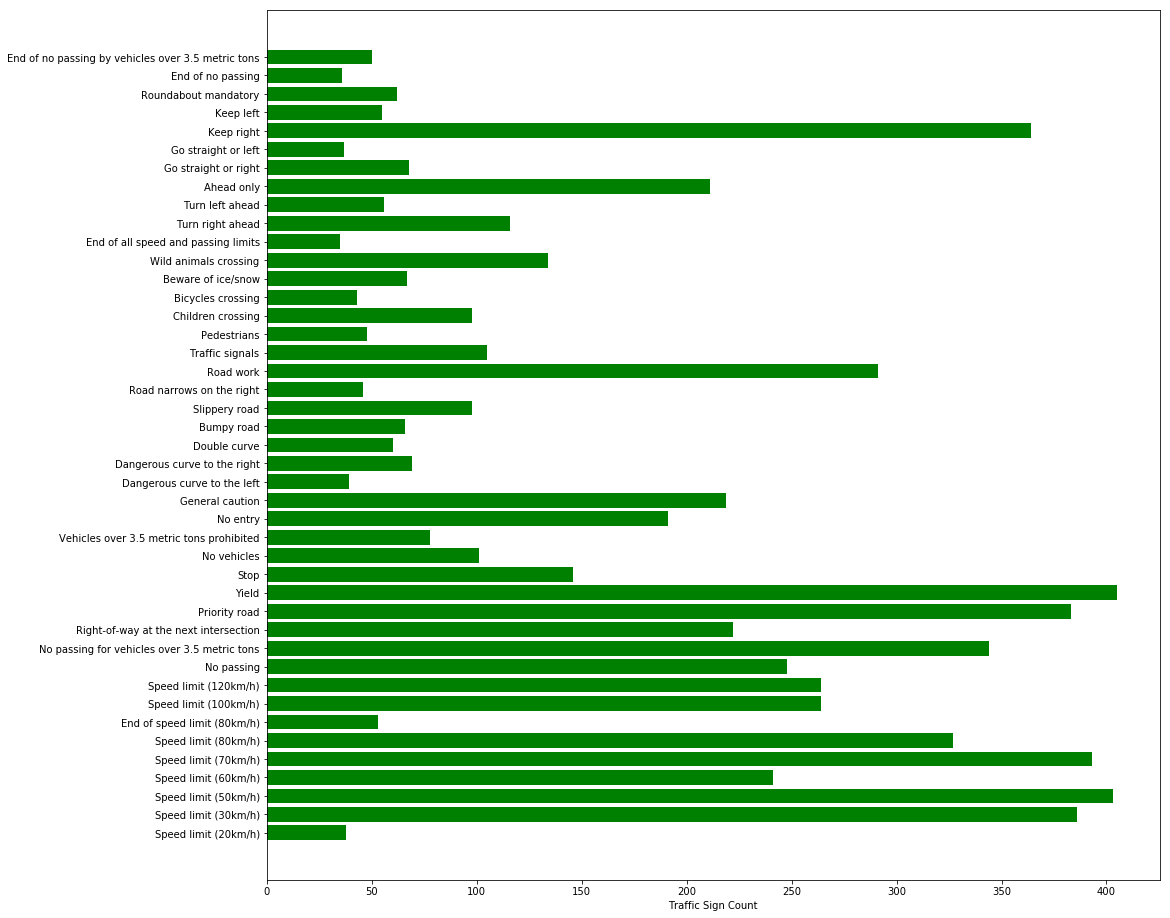

In [61]:
# Visualise Validation Set
plothist(y_valid,label_dict)

## The LeNet5 architecture
The LeNet5 architecture is written as a python class definition with appropraite variables that can be iterated. This enables a user to create any number of LeNet5 architecture object to try out differnt model types.

Two runs will be perfomed on the current training and validation set without any modification to the LeNet5 architecture. This is to understand the minimalist performace of the model on the traffic sign dataset.

- A run with current architecure as baseline.
- A run with low learning rate to understand the implications

### Run 1- Baseline

In [62]:
# Create an Object of the LeNet5
lenet5obj = lenet5.neuralLeNet(X_train, y_train, X_valid, y_valid, X_test, y_test)

# Setup Process
lenet5obj.process_setup(EPOCHS=10, BATCH_SIZE=256, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43)
# Setup training
lenet5obj.setup_train_pipe(learning_rate=0.001)

# Sstart training
lenet5obj.train()

Training...

EPOCH 1 ...Validation Accuracy = 0.479
EPOCH 2 ...Validation Accuracy = 0.760
EPOCH 3 ...Validation Accuracy = 0.861
EPOCH 4 ...Validation Accuracy = 0.896
EPOCH 5 ...Validation Accuracy = 0.914
EPOCH 6 ...Validation Accuracy = 0.921
EPOCH 7 ...Validation Accuracy = 0.937
EPOCH 8 ...Validation Accuracy = 0.936
EPOCH 9 ...Validation Accuracy = 0.939
EPOCH 10 ...Validation Accuracy = 0.944


### Run 2- Learning rate 0.0005

In [38]:
# Create an Object of the LeNet5
lenet5obj_drop = lenet5.neuralLeNet(X_train, y_train, X_valid, y_valid, X_test, y_test)

# Setup Process
lenet5obj_drop.process_setup(EPOCHS=10, BATCH_SIZE=256, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43)
# Setup training
lenet5obj_drop.setup_train_pipe(learning_rate=0.0005)

# Sstart training
lenet5obj_drop.train()

Training...

EPOCH 1 ...Validation Accuracy = 0.596
EPOCH 2 ...Validation Accuracy = 0.779
EPOCH 3 ...Validation Accuracy = 0.854
EPOCH 4 ...Validation Accuracy = 0.887
EPOCH 5 ...Validation Accuracy = 0.905
EPOCH 6 ...Validation Accuracy = 0.925
EPOCH 7 ...Validation Accuracy = 0.932
EPOCH 8 ...Validation Accuracy = 0.940
EPOCH 9 ...Validation Accuracy = 0.945
EPOCH 10 ...Validation Accuracy = 0.934


----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Normalisation

Two different normalisation methods are evalauted. This will help the model train better.
- Normalisation using mean centering and Standard Deviation
- Normalisation using minmax scaler

In [8]:
def normalisebystd(dataset):
    '''
    This function will normalise a given array with mean and std. Deviation
    
    :param dataset: the test or train image 4d array to be normalised
    '''
    mean = dataset.mean()
    std = dataset.std()
    dset = (dataset - mean) / std
    return dset

def simplenormalise(dataset):
    '''
    This function will normalise a given array with mean and std. Deviation
    
    :param dataset: the test or train image 4d array to be normalised
    '''
    dset = (dataset - 128) / 128
    return dset

def minmaxscaler(dataset):
    '''
    This function performs min-max scaling for a given dataset
    '''
    xmin = dataset.min()
    xmax = dataset.max()
    dset = (dataset - xmin) / (xmax - xmin)
    return dset

In [12]:
# Normalise option 1
X_train = Org_X_train.copy()
y_train = Org_y_train.copy()

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

X_train = normalisebystd(X_train)
X_valid = normalisebystd(X_valid)

# Re Run Network to see the Performance
# Create an Object of the LeNet5
lenet5obj_Norm1 = lenet5.neuralLeNet(X_train, y_train, X_valid, y_valid, X_test, y_test)

# Setup Process
lenet5obj_Norm1.process_setup(EPOCHS=10, BATCH_SIZE=256, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43, dropout=0.5)

# Setup training
lenet5obj_Norm1.setup_train_pipe(learning_rate=0.001)

# Sstart training
lenet5obj_Norm1.train()

Training...

EPOCH 1 ...Validation Accuracy = 0.718
EPOCH 2 ...Validation Accuracy = 0.886
EPOCH 3 ...Validation Accuracy = 0.914
EPOCH 4 ...Validation Accuracy = 0.939
EPOCH 5 ...Validation Accuracy = 0.954
EPOCH 6 ...Validation Accuracy = 0.962
EPOCH 7 ...Validation Accuracy = 0.965
EPOCH 8 ...Validation Accuracy = 0.967
EPOCH 9 ...Validation Accuracy = 0.965
EPOCH 10 ...Validation Accuracy = 0.968


In [ ]:
# Normalisation option 3
X_train = Org_X_train.copy()
y_train = Org_y_train.copy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train = minmaxscaler(X_train)
X_valid = minmaxscaler(X_valid)

# Re Run Network to see the Performance
# Create an Object of the LeNet5
lenet5obj_Norm3 = lenet5.neuralLeNet(X_train, y_train, X_valid, y_valid, X_test, y_test)

# Setup Process
lenet5obj_Norm3.process_setup(EPOCHS=10, BATCH_SIZE=128, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43)

# Setup training
lenet5obj_Norm3.setup_train_pipe(learning_rate=0.001)

# Sstart training
lenet5obj_Norm3.train()

### Image Augumentation

Image augumentation is a key process in improving the model performance. In reality the model could receive images that can be rotated, poor quality or misisng information. In order for the model to perform in reasonable means as a human eye different augumentation has to be artifically introduced and trained. This enables the model to be robust.
Three differnt image augumentation is accomplised.

- Rotation
- Translation
- Image enhancement by noise reduction.

In [9]:
# Image Preprocessing
def rotation(image, angle=5):
    '''
    Rotates the image to a given angle and return the dataset with rotated image
    '''
    angle = np.random.uniform(-angle, angle)
    nrow, ncol = np.shape(image)[:2]
    scale = 1
    rot_matrix = cv2.getRotationMatrix2D((nrow/2, ncol/2), angle, scale)
    rot_img = cv2.warpAffine(image, rot_matrix, (ncol, nrow))
    return rot_img

def translate(image, trans_x, trans_y):
    '''
    This translates the image by the a and y value provided for translation.
    '''
    trans_x = np.random.uniform(-trans_x, trans_x)
    trans_y = np.random.uniform(-trans_y, trans_y)
    nrow, ncol = np.shape(image)[:2]
    trans_matrix = np.float32([[1,0,trans_x],[0,1,trans_y]])
    trans_img = cv2.warpAffine(image, trans_matrix, (ncol,nrow))
    return trans_img

def enhance_image(image, kernel_size, weight):
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return cv2.addWeighted(image, weight, blurred, -weight, image.mean())

### Colour Space Study

In order to understand the model behaviour and robustness, differnet colourspace are analysed.
- Grayscale
- HSV
- YUV

In [10]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel, The dimension is reset 3D array."""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)[:,:,np.newaxis]

def HSV(img):
    """
    converts the given RGB image to HSV colour space
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def YUV(img):
    """
    converts the RGB image to YUV colour space
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

100%|██████████| 27839/27839 [00:01<00:00, 25981.82it/s]


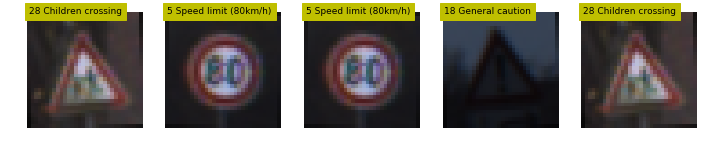

Training...

EPOCH 1 ...Validation Accuracy = 0.519
EPOCH 2 ...Validation Accuracy = 0.775
EPOCH 3 ...Validation Accuracy = 0.851
EPOCH 4 ...Validation Accuracy = 0.882
EPOCH 5 ...Validation Accuracy = 0.897
EPOCH 6 ...Validation Accuracy = 0.916
EPOCH 7 ...Validation Accuracy = 0.925
EPOCH 8 ...Validation Accuracy = 0.929
EPOCH 9 ...Validation Accuracy = 0.939
EPOCH 10 ...Validation Accuracy = 0.945


In [125]:
# Running Training to understand the performance on Image transformations
# Image Rotation
X_train = Org_X_train.copy()
y_train = Org_y_train.copy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train_new = []
for i in tqdm(range(np.shape(X_train)[0])):
    X_train_new.append(rotation(X_train[i], angle = 3))

X_train_new = np.array(X_train_new)

# Plot some new rotated image
# Get random set of traffic sign to visualise them
dataset, label = getrandomset(X_train_new, y_train, 5)
# generate label dictionary to identify the traffic signs
label_dict = readLabel(signcsvname)
# Plot traffic signs
plotrandom(dataset, label, label_dict)

# Re Run Network to see the Performance
# Create an Object of the LeNet5
lenet5obj_rot = lenet5.neuralLeNet(X_train_new, y_train, X_valid, y_valid)

# Setup Process
lenet5obj_rot.process_setup(EPOCHS=10, BATCH_SIZE=256, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43)

# Setup training
lenet5obj_rot.setup_train_pipe(learning_rate=0.001)

# Sstart training
lenet5obj_rot.train()

100%|██████████| 27839/27839 [00:01<00:00, 21368.76it/s]


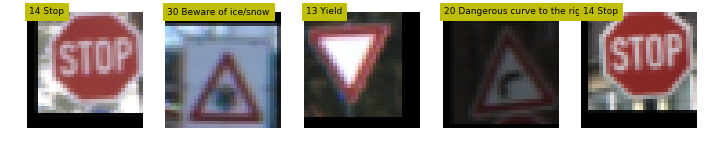

Training...

EPOCH 1 ...Validation Accuracy = 0.200
EPOCH 2 ...Validation Accuracy = 0.355
EPOCH 3 ...Validation Accuracy = 0.452
EPOCH 4 ...Validation Accuracy = 0.510
EPOCH 5 ...Validation Accuracy = 0.559
EPOCH 6 ...Validation Accuracy = 0.598
EPOCH 7 ...Validation Accuracy = 0.639
EPOCH 8 ...Validation Accuracy = 0.658
EPOCH 9 ...Validation Accuracy = 0.675
EPOCH 10 ...Validation Accuracy = 0.693


In [127]:
# Running Training to understand the performance on Image transformations
# Image Translation
X_train = Org_X_train.copy()
y_train = Org_y_train.copy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train_new = []
for i in tqdm(range(np.shape(X_train)[0])):
    X_train_new.append(translate(X_train[i], 5, 6))

X_train_new = np.array(X_train_new)

# Plot some new rotated image
# Get random set of traffic sign to visualise them
dataset, label = getrandomset(X_train_new, y_train, 5)
# generate label dictionary to identify the traffic signs
label_dict = readLabel(signcsvname)
# Plot traffic signs
plotrandom(dataset, label, label_dict)

# Re Run Network to see the Performance
# Create an Object of the LeNet5
lenet5obj_trans = lenet5.neuralLeNet(X_train_new, y_train, X_valid, y_valid)

# Setup Process
lenet5obj_trans.process_setup(EPOCHS=10, BATCH_SIZE=256, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43)

# Setup training
lenet5obj_trans.setup_train_pipe(learning_rate=0.001)

# Sstart training
lenet5obj_trans.train()

In [128]:
# Running Training to understand the performance on Image transformations
# Image GrayScale
X_train = Org_X_train.copy()
y_train = Org_y_train.copy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train_new = []
X_valid_new = []
for i in tqdm(range(np.shape(X_train)[0])):
    X_train_new.append(grayscale(X_train[i]))

for i in tqdm(range(np.shape(X_valid)[0])):
    X_valid_new.append(grayscale(X_valid[i]))

X_train_new = np.array(X_train_new)
print(np.shape(X_train_new))
print(np.shape(X_valid_new))
# Re Run Network to see the Performance
# Create an Object of the LeNet5
lenet5obj_gray = lenet5.neuralLeNet(X_train_new, y_train, X_valid_new, y_valid)

# Setup Process
lenet5obj_gray.process_setup(EPOCHS=10, BATCH_SIZE=128, mu=0, sigma=0.1,
                        inputshape=(5, 5, 1, 6), x_shape=(None, 32, 32, 1),
                        y_shape=(None), onehot_class=43, outputclass=43)

# Setup training
lenet5obj_gray.setup_train_pipe(learning_rate=0.001)

# Sstart training
lenet5obj_gray.train()

100%|██████████| 6960/6960 [00:00<00:00, 85297.16it/s]


(27839, 32, 32, 1)
(6960, 32, 32, 1)
Training...

EPOCH 1 ...Validation Accuracy = 0.711
EPOCH 2 ...Validation Accuracy = 0.859
EPOCH 3 ...Validation Accuracy = 0.900
EPOCH 4 ...Validation Accuracy = 0.919
EPOCH 5 ...Validation Accuracy = 0.928
EPOCH 6 ...Validation Accuracy = 0.940
EPOCH 7 ...Validation Accuracy = 0.947
EPOCH 8 ...Validation Accuracy = 0.945
EPOCH 9 ...Validation Accuracy = 0.950
EPOCH 10 ...Validation Accuracy = 0.955


100%|██████████| 6960/6960 [00:00<00:00, 40994.22it/s]


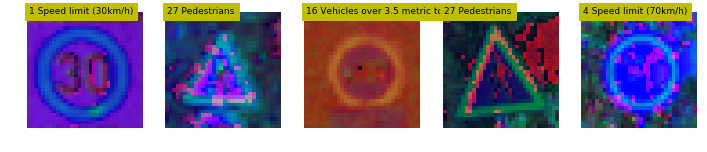

Training...

EPOCH 1 ...Validation Accuracy = 0.367
EPOCH 2 ...Validation Accuracy = 0.553
EPOCH 3 ...Validation Accuracy = 0.655
EPOCH 4 ...Validation Accuracy = 0.729
EPOCH 5 ...Validation Accuracy = 0.782
EPOCH 6 ...Validation Accuracy = 0.814
EPOCH 7 ...Validation Accuracy = 0.836
EPOCH 8 ...Validation Accuracy = 0.850
EPOCH 9 ...Validation Accuracy = 0.882
EPOCH 10 ...Validation Accuracy = 0.893


In [130]:
# Running Training to understand the performance on Image transformations
# Image HSV
X_train = Org_X_train.copy()
y_train = Org_y_train.copy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train_new = []
X_valid_new = []
for i in tqdm(range(np.shape(X_train)[0])):
    X_train_new.append(HSV(X_train[i]))

for i in tqdm(range(np.shape(X_valid)[0])):
    X_valid_new.append(HSV(X_valid[i]))

X_train_new = np.array(X_train_new)
X_valid_new = np.array(X_valid_new)

# Plot some new rotated image
# Get random set of traffic sign to visualise them
dataset, label = getrandomset(X_train_new, y_train, 5)
# generate label dictionary to identify the traffic signs
label_dict = readLabel(signcsvname)
# Plot traffic signs
plotrandom(dataset, label, label_dict)

# Re Run Network to see the Performance
# Create an Object of the LeNet5
lenet5obj_HSV = lenet5.neuralLeNet(X_train_new, y_train, X_valid_new, y_valid)

# Setup Process
lenet5obj_HSV.process_setup(EPOCHS=10, BATCH_SIZE=128, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43)

# Setup training
lenet5obj_HSV.setup_train_pipe(learning_rate=0.001)

# Sstart training
lenet5obj_HSV.train()

100%|██████████| 6960/6960 [00:00<00:00, 73291.65it/s]


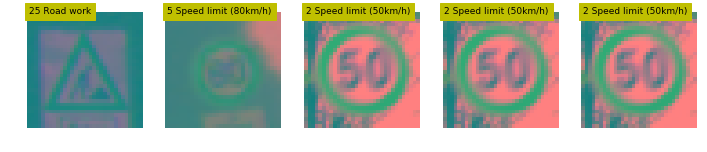

Training...

EPOCH 1 ...Validation Accuracy = 0.625
EPOCH 2 ...Validation Accuracy = 0.793
EPOCH 3 ...Validation Accuracy = 0.863
EPOCH 4 ...Validation Accuracy = 0.904
EPOCH 5 ...Validation Accuracy = 0.922
EPOCH 6 ...Validation Accuracy = 0.934
EPOCH 7 ...Validation Accuracy = 0.937
EPOCH 8 ...Validation Accuracy = 0.938
EPOCH 9 ...Validation Accuracy = 0.947
EPOCH 10 ...Validation Accuracy = 0.942


In [131]:
# Running Training to understand the performance on Image transformations
# Image YUV
X_train = Org_X_train.copy()
y_train = Org_y_train.copy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train_new = []
X_valid_new = []
for i in tqdm(range(np.shape(X_train)[0])):
    X_train_new.append(YUV(X_train[i]))

for i in tqdm(range(np.shape(X_valid)[0])):
    X_valid_new.append(YUV(X_valid[i]))

X_train_new = np.array(X_train_new)
X_valid_new = np.array(X_valid_new)

# Plot some new rotated image
# Get random set of traffic sign to visualise them
dataset, label = getrandomset(X_train_new, y_train, 5)
# generate label dictionary to identify the traffic signs
label_dict = readLabel(signcsvname)
# Plot traffic signs
plotrandom(dataset, label, label_dict)

# Re Run Network to see the Performance
# Create an Object of the LeNet5
lenet5obj_YUV = lenet5.neuralLeNet(X_train_new, y_train, X_valid_new, y_valid)

# Setup Process
lenet5obj_YUV.process_setup(EPOCHS=10, BATCH_SIZE=128, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43)

# Setup training
lenet5obj_YUV.setup_train_pipe(learning_rate=0.001)

# Sstart training
lenet5obj_YUV.train()

### Better train and validation dataset

In order to improve the model performance the orginal training set will be image augumented and added to the training set. This help the model understand all the images in different conditions in good and bad quality.

### Model Architecture

The following architecture will be finally used to train the traffic sign classifier.
- Epoch - 100
- Batch Size - 128
- Mu - 0
- Sigma - 0.1
- Dropout - 0.5
- Normlisation - (x- mean / Std.Deviation)
- Image Rotation, Translation and improve sharpness (using Gaussian Blur)
- No change in colour space

This setting will be used to asses the classifier as a whole.

The acutal code is a Python class lenet5

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:
X_train = Org_X_train.copy()
y_train = Org_y_train.copy()

X_train_new = []

for i in tqdm(range(np.shape(X_train)[0])):
    img = enhance_image(X_train[i], 9, 8)
    img = rotation(img, angle = 3)
    img = translate(img, 5, 5)
    X_train_new.append(img)

X_train_new = np.array(X_train_new)
X_Train_Total = np.concatenate((X_train, X_train_new))
Y_Train_Total = np.concatenate((y_train, y_train))

X_Train_Total, Y_Train_Total = shuffle(X_Train_Total, Y_Train_Total)
x_train_run, x_valid_run, y_train_run, y_valid_run = train_test_split(X_Train_Total, Y_Train_Total,
                                                                      test_size=0.2, random_state=0)

x_train_run = normalisebystd(x_train_run)
x_valid_run = normalisebystd(x_valid_run)

# Re Run Network to see the Performance
# Create an Object of the LeNet5
lenet5final_test = lenet5.neuralLeNet(x_train_run, y_train_run, x_valid_run, y_valid_run)

# Setup Process
lenet5final_test.process_setup(EPOCHS=100, BATCH_SIZE=128, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43, dropout=0.5)

# Setup training
lenet5final_test.setup_train_pipe(learning_rate=0.001)

# Sstart training
lenet5final_test.train("./Final_TSR_Model_Update")


100%|██████████| 34799/34799 [00:05<00:00, 6159.17it/s]


Training...

EPOCH 1 ...Validation Accuracy = 0.666
EPOCH 2 ...Validation Accuracy = 0.792
EPOCH 3 ...Validation Accuracy = 0.843
EPOCH 4 ...Validation Accuracy = 0.867
EPOCH 5 ...Validation Accuracy = 0.881
EPOCH 6 ...Validation Accuracy = 0.893
EPOCH 7 ...Validation Accuracy = 0.898
EPOCH 8 ...Validation Accuracy = 0.894
EPOCH 9 ...Validation Accuracy = 0.908
EPOCH 10 ...Validation Accuracy = 0.919
EPOCH 11 ...Validation Accuracy = 0.916
EPOCH 12 ...Validation Accuracy = 0.916
EPOCH 13 ...Validation Accuracy = 0.918
EPOCH 14 ...Validation Accuracy = 0.919
EPOCH 15 ...Validation Accuracy = 0.926
EPOCH 16 ...Validation Accuracy = 0.922
EPOCH 17 ...Validation Accuracy = 0.927
EPOCH 18 ...Validation Accuracy = 0.928
EPOCH 19 ...Validation Accuracy = 0.927
EPOCH 20 ...Validation Accuracy = 0.931
EPOCH 21 ...Validation Accuracy = 0.924
EPOCH 22 ...Validation Accuracy = 0.931
EPOCH 23 ...Validation Accuracy = 0.935
EPOCH 24 ...Validation Accuracy = 0.930
EPOCH 25 ...Validation Accuracy = 0.

In [13]:
# Prepare the test data
X_test_new = []
for i in tqdm(range(np.shape(X_test)[0])):
    img = enhance_image(X_test[i], 9, 8)
    img = rotation(img, angle = 3)
    img = translate(img, 5, 5)
    X_test_new.append(img)

X_test_new = np.array(X_test_new)
X_test_new = normalisebystd(X_test_new)

lenet5final_test.test('.', X_test_new, y_test)



100%|██████████| 12630/12630 [00:02<00:00, 6198.64it/s]


Test Accuracy = 0.845


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [13]:
# A function to load the test images. The images are converted to 32,32 size as they are the input to our model
def loadtest(testfolder):
    '''
    This function loads the test set and prepares the image
    '''
    flist = glob.glob(os.path.join(testfolder,"*.jpg"))
    img_list = [cv2.imread(x) for x in flist]
    img_list_RGB = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in img_list]
    reszied_list= [cv2.resize(x,(32, 32), interpolation = cv2.INTER_CUBIC) for x in img_list_RGB]
    return np.array(reszied_list), np.array(img_list)

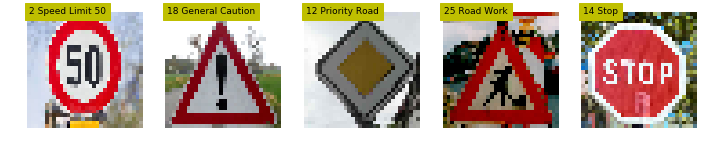

In [103]:
# Load the image and plot
Test_Folder = "./Traffic_Sign_Test"
T_test, org_img = loadtest(Test_Folder)
T_label = np.array([2,18,12,25,14])

sign_label = {2  : "Speed Limit 50",
              18 : "General Caution",
              12 : "Priority Road",
              25 : "Road Work",
              14 : "Stop"}
#Plot Images
plotrandom(T_test, T_label, sign_label)


### Predict the Sign Type for Each Image

In [21]:
# PreProcessing for the test image

T_test_new = []
for i in tqdm(range(np.shape(T_test)[0])):
    img = enhance_image(T_test[i], 9, 8)
    img = rotation(img, angle = 3)
    img = translate(img, 5, 5)
    T_test_new.append(img)

T_test_new = np.array(T_test_new)
T_test_new = normalisebystd(T_test_new)

100%|██████████| 5/5 [00:00<00:00, 2941.31it/s]


### Analyze Performance

There are 5 images of the German traffic sign used from the web. The  model predicted 4 out of 5 correctly with 80% accuracy on the new images.

The General Caution sign is detected as traffic signal incorrectly and this probably due to close resemblence to trafffic signal after the image agumentation sign. Fine tune of the model and high train accuracy can yield better detection capability

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [121]:
### Soft Max Function
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax = tf.nn.softmax(lenet5final_test.logits)
    result = sess.run(softmax, feed_dict={lenet5final_test.x: T_test_new})
    values, indices = tf.nn.top_k(result, 5)
    probs = sess.run(values)
    predictions = sess.run(indices)

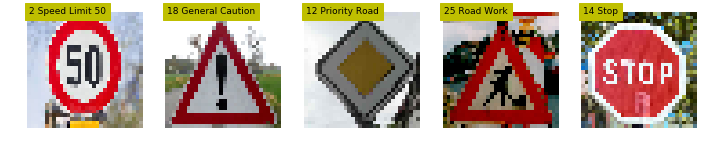

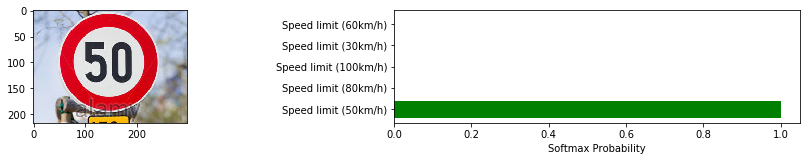

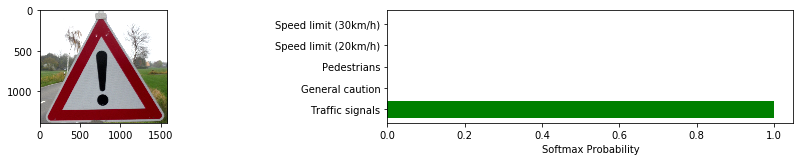

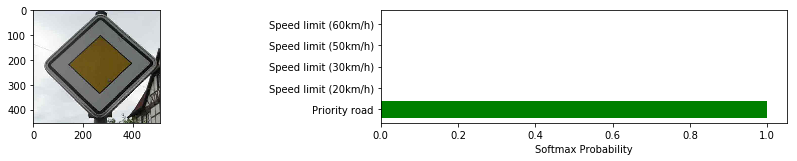

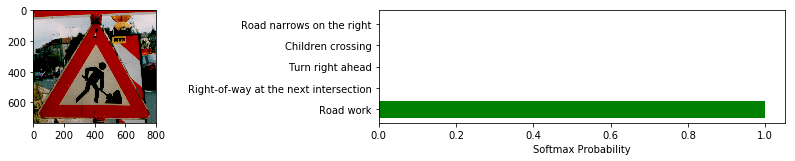

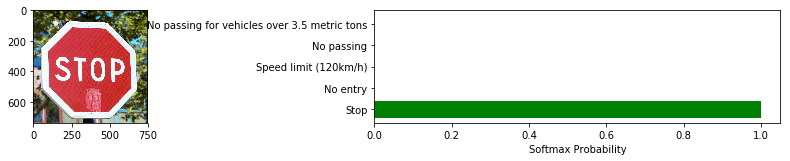

In [22]:
# Load the image and plot
Test_Folder = "./Traffic_Sign_Test"
T_test, org_img = loadtest(Test_Folder)
T_label = np.array([2,18,12,25,14])

sign_label = {2  : "Speed Limit 50",
              18 : "General Caution",
              12 : "Priority Road",
              25 : "Road Work",
              14 : "Stop"}
#Plot Images
plotrandom(T_test, T_label, sign_label)

for ix,idx in enumerate(np.arange(0,10,2)):
    width = 16
    height = 12
    plt.figure(figsize=(width, height))
    plt.subplot(5,2,idx+1)
    plt.imshow(cv2.cvtColor(org_img[ix], cv2.COLOR_BGR2RGB))
    plt.subplot(5,2,idx+2)
    label = [label_dict[key] for key in predictions[ix]]
    ypos= np.arange(len(label)) + 1
    plt.barh(ypos, probs[ix], align='center', color='green', ecolor='black')
    plt.yticks(ypos,label)
    plt.xlabel("Softmax Probability")

In [41]:
# Print out Softmax
for idx,(pro,pred) in enumerate(zip(probs,predictions)):
    print(sign_label[T_label[idx]])
    print("_" * 80)
    print()
    for idx,sign in enumerate(pred):
        print("{:>50}            {:.15f}".format(label_dict[sign], pro[idx]))

Speed Limit 50
________________________________________________________________________________

                              Speed limit (50km/h)            0.999966740608215
                              Speed limit (80km/h)            0.000033241572964
                             Speed limit (100km/h)            0.000000000000442
                              Speed limit (30km/h)            0.000000000000000
                              Speed limit (60km/h)            0.000000000000000
General Caution
________________________________________________________________________________

                                   Traffic signals            0.999866366386414
                                   General caution            0.000133650217322
                                       Pedestrians            0.000000000000896
                              Speed limit (20km/h)            0.000000000000000
                              Speed limit (30km/h)            0.000000000000000
Prior